<img align="right" width="400" src="https://drive.google.com/thumbnail?id=1rPeHEqFWHJcauZlU82a4hXM10TUjmHxM&sz=s4000" alt="FHNW Logo">


# Build a RAG System

by Fabian Märki

## Summary
The aim of this notebook is to illustrate how to build a RAG.

## Links
- [A Comprehensive Guide to RAG](https://www.chatbees.ai/blog/rag-nlp)
- [LangChain RAG Tutorial](https://python.langchain.com/docs/tutorials/rag/) with a [Detailed Walkthrough](https://python.langchain.com/docs/tutorials/rag/#detailed-walkthrough) (worth reading)
- [Haystack RAG Tutorial](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline)
- [RAG for LLMs](https://www.promptingguide.ai/research/rag)

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/2025_HS_Advanced_NLP_LAB/blob/master/05_a_Build_a_RAG_System.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#OLLAMA_HOST='https://XYZ.trycloudflare.com'
OLLAMA_HOST='http://localhost:11434'
OPENAI_BASE_URL=OLLAMA_HOST+"/v1/"

In [2]:
%%capture

!pip install 'fhnw-nlp-utils>=0.11.0,<0.12.0'

from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.transformers import get_compute_device

import pandas as pd
import numpy as np

In [3]:
%%capture

!pip install pypdf
!pip install langchain-community==0.3.10
!pip install langchain-ollama==0.3.10
!pip install langchain_openai==0.3.10
!pip install langchain-huggingface==0.3.10
!pip install chromadb

Enable verbose/debug to see detailed output (see [here](https://python.langchain.com/docs/how_to/debugging/#set_debug-and-set_verbose).

In [4]:
from langchain.globals import set_verbose
from langchain.globals import set_debug

set_verbose(False)
set_debug(False)

## Document Preparation

<img src="https://drive.switch.ch/index.php/s/qSIM5OGsGrqdaOl/download" alt="RAG Indexing">
Illustration of the document ingestion pipeline.

### Download and Load the Documents

We will do some queries on the menu of a restaurant.

In [5]:
pdf_folder = "data/pdfs"

menu_dinner = pdf_folder + "/Menu_Dinner.pdf"
menu_kids = pdf_folder + "/Menu_Kids.pdf"
menu_week_specials = pdf_folder + "/Menu_Week_Specials.pdf"

download("https://drive.switch.ch/index.php/s/lWUezzWeYUv3Vc6/download", menu_dinner)
download("https://drive.switch.ch/index.php/s/VmjVLTmvv1mgtB1/download", menu_kids)
download("https://drive.switch.ch/index.php/s/bV5n4BxkSb2JWdP/download", menu_week_specials)

There are document loaders for different formats available:
- LangChain provides a multitude of [document loaders](https://python.langchain.com/docs/integrations/document_loaders/) for different sources
- Load a single [PDF document](https://python.langchain.com/docs/how_to/document_loader_pdf/)


In [6]:
from langchain_community.document_loaders import PyPDFDirectoryLoader

loader = PyPDFDirectoryLoader(pdf_folder)
documents = loader.load()

Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 13 0 (offset 0)
Ignoring wrong pointing object 15 0 (offset 0)
Ignoring wrong pointing object 21 0 (offset 0)


### Split the Documents into Chunks

- LangChain's text splitters [API reference](https://python.langchain.com/api_reference/text_splitters/index.html)
- Haystack's text splitters [API reference](https://docs.haystack.deepset.ai/docs/documentsplitter)
- [Visualize](https://chunkviz.up.railway.app/) different chunking/splitting strategies
- [Mastering Text Splitting in LangChain](https://medium.com/@harsh.vardhan7695/mastering-text-splitting-in-langchain-735313216e01) 

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter()
#splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", ".", "?", "!", ":", ","], chunk_size=512, chunk_overlap=64, length_function=len)
chunks = splitter.split_documents(documents)

In [8]:
print(chunks[5])

page_content='3. GRILLED CHEESE SANDWICH
●
●
●
Description: Melted cheese between slices of buttered bread, grilled to perfection.
Allergens: Dairy, Gluten.
Suitable for Vegetarians: Yes
4. SPAGHETTI WITH MARINARA SAUCE
●
●
●
Description: Kid-friendly spaghetti noodles topped with tomato marinara sauce.
Allergens: Gluten.
Suitable for Vegetarians: Yes
5. MINI PITA PIZZA
●
●
●
Description: Small pita bread topped with tomato sauce, cheese, and favorite toppings.
Allergens: Dairy, Gluten.
Suitable for Vegetarians: Yes
Desserts:
1. MINI ICE CREAM SUNDAE
●
●
●
Description: A scoop of vanilla ice cream with chocolate sauce and rainbow sprinkles.
Allergens: Dairy.
Suitable for Vegetarians: Yes
2. FRUIT KABOBS
●
●
●
Description: Fresh fruit chunks on skewers for a fun and healthy dessert.
Allergens: None.
Suitable for Vegetarians: Yes
3. CHOCOLATE CHIP COOKIE BITES
●
●
●
Description: Bite-sized chocolate chip cookies.
Allergens: Dairy, Gluten.
Suitable for Vegetarians: Yes
4. BANANA SPLIT
●
●

<font color='red'>**Task: Try a different TextSplitter and see if it makes a difference (see above for interesting links).**</font>

In [9]:
splitter = ...

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
print(chunks[5])

page_content='3.

GRILLED CHEESE SANDWICH
●
●
●
Description: Melted cheese between slices of buttered bread, grilled to perfection.

Allergens: Dairy, Gluten.

Suitable for Vegetarians: Yes
4.

SPAGHETTI WITH MARINARA SAUCE
●
●
●
Description: Kid-friendly spaghetti noodles topped with tomato marinara sauce.

Allergens: Gluten.

Suitable for Vegetarians: Yes
5.

MINI PITA PIZZA
●
●
●
Description: Small pita bread topped with tomato sauce, cheese, and favorite toppings.

Allergens: Dairy, Gluten.

Suitable for Vegetarians: Yes
Desserts:
1.

MINI ICE CREAM SUNDAE
●
●
●
Description: A scoop of vanilla ice cream with chocolate sauce and rainbow sprinkles.

Allergens: Dairy.

Suitable for Vegetarians: Yes
2.

FRUIT KABOBS
●
●
●
Description: Fresh fruit chunks on skewers for a fun and healthy dessert.

Allergens: None.

Suitable for Vegetarians: Yes
3.

CHOCOLATE CHIP COOKIE BITES
●
●
●
Description: Bite-sized chocolate chip cookies.

Allergens: Dairy, Gluten.

Suitable for Vegetarians: Yes
4

## Embed the Documents (i.e. the Chunks)

### Access Ollama to Embed Documents
Let's use Ollama (see [here](https://ollama.com/blog/embedding-models) and [here](https://python.langchain.com/docs/integrations/text_embedding/ollama/)) to embed our text. Models are available from [here](https://ollama.com/search?c=embedding).

In [11]:
from langchain_ollama import OllamaEmbeddings

In [12]:
MODEL_EMBEDDING = "nomic-embed-text"

# ensure (in your environment) that the model is installed
#
# !ollama pull <your_model>
# docker exec -it ollama sh -c "ollama pull <your_model>"

embedder = OllamaEmbeddings(
    model=MODEL_EMBEDDING,
    base_url=OLLAMA_HOST,
)

### Run an Embedder Locally 

Alternatively, you can use [Sentence Transformers](https://www.sbert.net) (or see [here](https://huggingface.co/sentence-transformers) or [here](https://huggingface.co/recipe/embeddings)) to embed our text using a model that runs locally. Models are available from [here](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html) or [here](https://huggingface.co/models?library=sentence-transformers&sort=downloads).

In [13]:
# enable if you want to run a local model (and the bug mentioned above got resolved)
run_locally = False

**Make sure that a GPU is available (see [here](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm))!!!**

In [14]:
from langchain_huggingface import HuggingFaceEmbeddings

if run_locally:
    model_name_embedder = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2" #"sentence-transformers/all-mpnet-base-v2"
    model_kwargs_embedder = {"device": get_compute_device()}

    embedder = HuggingFaceEmbeddings(model_name=model_name_embedder, model_kwargs=model_kwargs_embedder)

### Test the Embedder 

Let's do a quick similarity check...

In [15]:
sentences = [
    "Machine learning is very interesting.",
    "I enjoy deep learning.",
    "That is a happy person.",
    "That is a happy dog.",
    "That is a very happy person.",
    "Today is a sunny day.",
    "The weather forecast for this week is mostly sunny.",
    "I like to be in my apartment.", 
    "I enjoy staying home.", 
    "The isotope 238u decays to 206pb."
]

embeddings = embedder.embed_documents(sentences)

<Axes: >

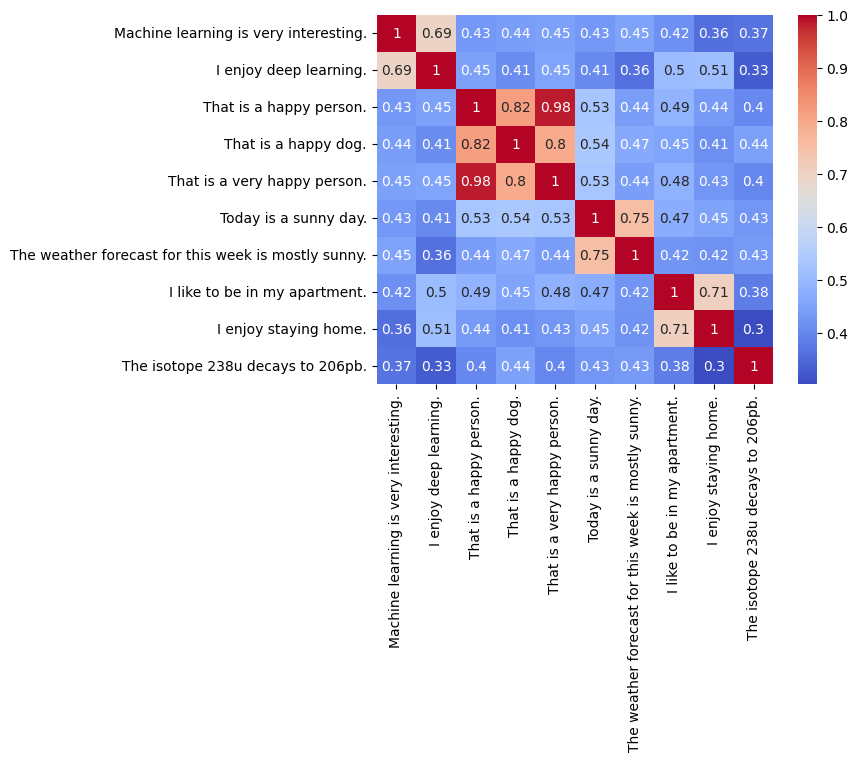

In [16]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_matrix = cosine_similarity(embeddings)

sns.heatmap(cos_sim_matrix, annot=True, cmap='coolwarm', xticklabels=sentences, yticklabels=sentences)

## Store the Embeddings/Chunks

See [here](https://python.langchain.com/docs/integrations/vectorstores/chroma/) for the detailed API of the Chroma vector store (e.g. how to add/update documents).

In [17]:
# cleanup (in case of re-execution to prevent duplicate entries)
!rm -rf chroma_db

<font color='red'>**Task: Setup the Chroma vectorstore (see above for interesting links).**</font>

In [18]:
from langchain.vectorstores import Chroma

vectorstore = Chroma.from_documents(
    ...
    persist_directory="chroma_db")

# alternative without additional dependencies (but not recommended for production)
# see https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html#inmemoryvectorstore
#from langchain_core.vectorstores import InMemoryVectorStore
#vectorstore = InMemoryVectorStore(embedder)
#vectorstore.add_documents(documents=all_splits)

## Setup the Retriever

Let's test the retriever... see [here](https://python.langchain.com/docs/concepts/vectorstores/) and [here](https://python.langchain.com/docs/how_to/vectorstore_retriever/) for details.

<font color='red'>**Task: Setup the retriever. You might want to use Maximal Marginal Relevance (MMR) which attempts to diversify the results of a search to avoid returning similar and redundant documents (see above for interesting links).**</font>

In [19]:
retriever = ...

retrieved_docs = retriever.invoke("What are the lunch specials on Tuesday?")

In [20]:
for idx, retrieved_doc in enumerate(retrieved_docs):
    print(idx, "Chunk: \n")
    print(retrieved_doc)
    print("-"*100, "\n\n")

0 Chunk: 

page_content='The Regrettable Experience – Week specials  Monday Lunch Specials • Soup of the Day: Hearty Lentil Soup (Vegetarian/Vegan)  • Salad: Grilled Chicken Caesar Salad  Allergens: Dairy (in dressing), Gluten (in croutons), Eggs (in dressing)  • Sandwich: BLT Wrap with Avocado  Allergens: Gluten (in wrap)  Tuesday Lunch Special  • Soup of the Day: Creamy Tomato Basil (Vegetarian)  Allergens: Dairy  • Salad: Strawberry Spinach Salad with Balsamic Vinaigrette  Allergens: Potential Tree Nuts (in vinaigrette)  Quiche: Broccoli and Cheddar Quiche  Allergens: Dairy, Eggs, Gluten (in crust)  Wednesday Lunch Special  • Soup of the Day: Chicken Tortilla Soup  Allergens: Dairy, Gluten (in tortilla strips)  • Salad: Greek Salad with Feta and Olives  Allergens: Dairy (in feta)  • Flatbread: Margherita Flatbread  Allergens: Dairy, Gluten  Thursday Lunch Special  • Soup of the Day: Black Bean Soup (Vegetarian/Vegan)  • Salad: Southwest Chicken Salad with Avocado Ranch  Allergens: D

### Improve Retrieval with a Reranker [Optional]

RAG performs a semantic search across many text documents (up to billions of documents). We typically use vector search to ensure fast search times (i.e. we transform text into vector space and compare their proximity to a query vector using a similarity metric like cosine similarity). 

These vectors are essentially compressions of the "meaning" behind the text. Compressing this information into a single vector results in information loss. Due to this information loss, we often see that the top three (for example) returned documents will miss relevant information (i.e. the retriever would only return relevant information below our top_k cutoff).

Why not just increasing the top_k cutoff and stuff more into the LLM? Unfortunately, we cannot return everything. LLMs have limits on how much text they can process. Even though some LLMs have huge context windows (like e.g. 100K tokens), research shows that the recall of LLMs degrades as we put more tokens in the context window. Additionally, LLMs are also less likely to follow instructions as we stuff the context window — so context stuffing is a bad idea.

A reranker is a type of model that outputs a similarity score from a query and document pair. As such, a reranker is much more accurate than embedding models (but way slower). This score is then used to reorder the documents by relevance to the query. 

We basically build a two-stage system. In a first stage, an embedding model/retriever retrieves a set of relevant documents from a larger dataset (which is fast). In a second stage, the reranker is used to rerank those documents retrieved by the first stage (which is more accurate). This reduced set is then forwarded to the LLM.

Read [here](https://www.pinecone.io/learn/series/rag/rerankers/) and [here](https://python.langchain.com/docs/integrations/document_transformers/cross_encoder_reranker/) about Rerankers...

<img src="https://drive.switch.ch/index.php/s/taFGr7Cb7hTQ78S/download" alt="Reranker">

In [21]:
use_reranker = True

In [22]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

if use_reranker:
    model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
    compressor = CrossEncoderReranker(model=model, top_n=2)
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, base_retriever=retriever
    )

2025-05-31 10:52:07.174552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748688727.190385   60748 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748688727.195238   60748 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748688727.207432   60748 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748688727.207447   60748 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748688727.207449   60748 computation_placer.cc:177] computation placer alr

In [23]:
if use_reranker:
    retrieved_docs = compression_retriever.invoke("What are the lunch specials on Tuesday?")
    
    for idx, retrieved_doc in enumerate(retrieved_docs):
        print(idx, "Chunk: \n")
        print(retrieved_doc)
        print("-"*100, "\n\n")

0 Chunk: 

page_content='The Regrettable Experience – Week specials  Monday Lunch Specials • Soup of the Day: Hearty Lentil Soup (Vegetarian/Vegan)  • Salad: Grilled Chicken Caesar Salad  Allergens: Dairy (in dressing), Gluten (in croutons), Eggs (in dressing)  • Sandwich: BLT Wrap with Avocado  Allergens: Gluten (in wrap)  Tuesday Lunch Special  • Soup of the Day: Creamy Tomato Basil (Vegetarian)  Allergens: Dairy  • Salad: Strawberry Spinach Salad with Balsamic Vinaigrette  Allergens: Potential Tree Nuts (in vinaigrette)  Quiche: Broccoli and Cheddar Quiche  Allergens: Dairy, Eggs, Gluten (in crust)  Wednesday Lunch Special  • Soup of the Day: Chicken Tortilla Soup  Allergens: Dairy, Gluten (in tortilla strips)  • Salad: Greek Salad with Feta and Olives  Allergens: Dairy (in feta)  • Flatbread: Margherita Flatbread  Allergens: Dairy, Gluten  Thursday Lunch Special  • Soup of the Day: Black Bean Soup (Vegetarian/Vegan)  • Salad: Southwest Chicken Salad with Avocado Ranch  Allergens: D

In [24]:
if use_reranker:
    retriever = compression_retriever

### Build Retrieval and Generation 

<img src="https://drive.switch.ch/index.php/s/0VUddvuY0U9e9Tj/download" alt="RAG Retrieval Generation">
Illustration of the retrieval and generation process.

Let's use Ollama...

In [25]:
from langchain_openai import ChatOpenAI

In [26]:
MODEL_TEXT = "qwen3:4b"

llm = ChatOpenAI(
    model=MODEL_TEXT,
    api_key="ollama",
    base_url=OPENAI_BASE_URL,
)

Alternatively, there are also [HuggingFacePipeline](https://python.langchain.com/docs/integrations/llms/huggingface_pipelines/) and [HuggingFaceChat](https://python.langchain.com/api_reference/huggingface/chat_models/langchain_huggingface.chat_models.huggingface.ChatHuggingFace.html#langchain_huggingface.chat_models.huggingface.ChatHuggingFace) bindings which allow for accessing the LLM directly from your code... but it seems there is a [bug](https://github.com/langchain-ai/langchain/pull/25136). 

In [27]:
#import transformers
#import torch
#from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace
#from langchain_core.messages import HumanMessage, SystemMessage

#model_id_llm = "NousResearch/Meta-Llama-3.1-8B-Instruct"

#pipeline = transformers.pipeline(
#    "text-generation",
#    model=model_id_llm,
#    model_kwargs={
#        "torch_dtype": torch.bfloat16,
#        "quantization_config": {"load_in_4bit": True}
#    },
#    device_map="auto",
#    max_new_tokens=256,
#    do_sample=True,
#    top_k=500, 
#    top_p=0.8,
#    temperature=0.7,
#)

#llm_pipe = HuggingFacePipeline(pipeline=pipeline)
#llm = ChatHuggingFace(llm=llm_pipe, model_id=model_id_llm)

#messages = [
#    SystemMessage(content="You are a helpful assistant."),
#    HumanMessage(content="What happens when an unstoppable force meets an immovable object?"),
#]

## see also https://www.kaggle.com/code/kingabzpro/accessing-the-llama-3-2-lightweight-models
##llm_response = llm_pipe.invoke(messages)
#llm_response = llm.invoke(messages)

#print(llm_response)

In [28]:
# Convert loaded documents into strings by concatenating their content
# and ignoring metadata
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [29]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

RAG_TEMPLATE = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. /no_think

<context>
{context}
</context>

Answer the following question:

{question}"""

# Prompt Template: https://python.langchain.com/docs/concepts/prompt_templates/
rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

# LangChain Expression Language: https://python.langchain.com/docs/concepts/lcel/
chain = (
    RunnablePassthrough.assign(context=lambda input: format_docs(input["context"]))
    | rag_prompt
    | llm
    | StrOutputParser()
)

question = "What are the entrees in the children's menu?"

docs = vectorstore.similarity_search(question)

# Run
response = chain.invoke({"context": docs, "question": question})

print(response)

<think>

</think>

The entrees in the children's menu are: Chicken Nuggets, Macaroni and Cheese, Mini Cheese Quesadillas, Peanut Butter and Banana Sandwich, and Veggie Pita Pockets.


or directly using the chain...

In [30]:
qa_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

In [31]:
question = "What are the entrees in the children's menu?"
response = qa_chain.invoke(question)
print(response)

<think>

</think>

The entrees in the children's menu are: Chicken Nuggets, Macaroni and Cheese, Mini Cheese Quesadillas, Peanut Butter and Banana Sandwich, and Veggie Pita Pockets.


In [32]:
question = "What vegetarian options are in the children's menu?"
response = qa_chain.invoke(question)
print(response)

<think>

</think>

The vegetarian options in the children's menu are: MACARONI AND CHEESE, MINI CHEESE QUESADILLAS, PEANUT BUTTER AND BANANA SANDWICH (if using vegetarian peanut butter), and VEGGIE PITA POCKETS. The MAINS include FISH STICKS and MINI CHEESEBURGERS, but they are not suitable for vegetarians. There is also a Salad: BBQ Chicken Salad with Ranch and a Burger: Black Bean Veggie Burger with Sweet Potato Fries, but the latter has allergens.


In [33]:
question = "What are the week specials for lunch on Monday?"
response = qa_chain.invoke(question)
print(response)

<think>

</think>

The Monday lunch special includes a Hearty Lentil Soup (Vegetarian/Vegan), a Grilled Chicken Caesar Salad, and a BLT Wrap with Avocado. Allergens for these items include Dairy (in dressing), Gluten (in croutons), Eggs (in dressing), and Gluten (in wrap).


Let's try a different language (the model should be multimodal).

In [34]:
question = "Was sind die Wochenhits am Montag?"
response = qa_chain.invoke(question)
print(response)

<think>

</think>

Ich weiß nicht, was die Wochenhits am Montag sind. Die gegebene Kontextinformation ist nicht relevant für diese Frage.


<font color='red'>**Task: What could be the reason that German does not work even though the LLM is multilingual?**</font>

Does the retriever support German (see [here](https://huggingface.co/BAAI/bge-reranker-base) - you might want to re-try with `MODEL_EMBEDDING = "bge-m3"` and `use_reranker = False`)? 

Furthermore, you might want to set [debug/verbose](https://python.langchain.com/docs/how_to/debugging/#set_debug-and-set_verbose) to see what is going on under the hood. 

<font color='red'>**Task: Try different questions.**</font>

<font color='red'>**Task: Try to improve the RAG_TEMPLATE (the current seems to be quite generic).**</font>

## Next Steps

- Allow the LLM to remember your conversation by adding a [chat history](https://python.langchain.com/docs/tutorials/qa_chat_history/)
- Allow the LLM to answer questions by [retrieving information from the web](https://python.langchain.com/docs/integrations/tools/ddg/)
- Allow the LLM to [call tools](https://js.langchain.com/docs/how_to/tool_calling/) (e.g. to make reservations in your restaurant or [query the weather for specific locations](https://python.langchain.com/docs/tutorials/agents/))